# Building a nanoGPT

# 1) Data loading

In [ ]:
# Load dataset:
!wget https://raw.githubusercontent.com/Paradox3333/0-to-transformers/main/input.txt

--2024-09-27 16:38:47--  https://raw.githubusercontent.com/Paradox3333/Transformers-from-scratch/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.008s  

2024-09-27 16:38:48 (132 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# Read it in to inspect it:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# Look at the first 1000 characters:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# Here are all the unique characters that occur in this text:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# Interesting observation about non-printable characters such as "\n" and whitespace:
print(repr(''.join(chars)))
print(f'\n{chars[0] = }, {chars[1] = }, {chars[2] = }')

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

chars[0] = '\n', chars[1] = ' ', chars[2] = '!'


In [7]:
# Create a mapping from characters to integers through dictionary:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # Encoder: take a string, output a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: take a list of integers, output a string.

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# Encode the entire text dataset and store it into a torch.tensor:
import torch # we use PyTorch: https://pytorch.org

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # The 1000 characters we looked at earlier will look like this to the GPT.

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8  # Context window
train_data[:block_size+1]

# Done so the Transformer can work with different context lengths from 1 to "block_size".

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t] # because y is already a list shifted by 1
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # Random sampling. Create 4 integers (because "batch_size=4") from 0 to "len(data) - block_size" to
    # limit the range of possible starting indices. By subtracting block_size from len(data),
    # you make sure that the random index ix you choose always has enough space to get a full sequence of block_size
    # tokens without going beyond the end of the data.
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) # Slice from index i to i+context.
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # Shifted slicing.
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')
# Showing how many examples with different context length can be in a sequence:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

# NOTE: The examples are stacked in a tensor. Each row is 1 slice of the training set,
# and as far as the Transformer is concerned, it contains 32 unique examples 
# (since each sequence from 1 to block_size can be interpreted as an individual example,
# meaning each row of the (4,8)tensor contains 8 examples).
# Ex: When the input is "24" (xb[0]) the next character is "43" (yb[0]),
# when the input is "24, 43" the next character is "58", and so on.

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

# 2) Bigram Model Setup, Training, and Inference

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module): # Create model class as subclass of nn.Module.

    def __init__(self, vocab_size: int):
        super().__init__()
        # Each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=vocab_size)
        # In a bigram model, the task is to predict the next token based on the current token.
        # This embedding table essentially holds a direct "lookup" for the logits for the next token.

    def forward(self, idx: torch.tensor, targets: torch.tensor=None):

        # idx and targets are both (B,T) tensor of integers:
        logits = self.token_embedding_table(idx) # (B,T,C) = (batch_size, block_size, vocab_size) for us

        # But "cross_entropy" expects inputs with (C), (B,C), or (B,C,T), so we need to reshape:
        if targets is None:
          loss = None
        else:
          B, T, C = logits.shape
          logits = logits.view(B * T, C)  # Could also transpose the last 2 dimensions.
                                          # Here we just reshape to 2D so we list all examples one after the other.
          targets = targets.view(B * T)   # 1D input expected by "cross_entropy".
          loss = F.cross_entropy(logits, targets) # Loss.

        return logits, loss # logits.shape is (32,65).

    def generate(self, idx: torch.tensor, max_new_tokens: int):
      # idx is (B,T) array of indices in the current context:
      for _ in range (max_new_tokens):  # Generation loop.
        logits, loss = self(idx)  # Call a forward pass w/o targets --> (B,T,C)
        # Focus only on the last time step:
        logits = logits[:, -1, :] # becomes (B,C)
        # The line logits = logits[:, -1, :] selects the logits for the last token in each sequence,
        # but it does this for all sequences in the batch.
        # So, for each sequence in the batch, you're predicting the next token based on the last token in that sequence.
        # Apply softmax to get probabilities:
        probs = F.softmax(logits, dim=-1) # (B,C)
        # Sample from the distribution:
        idx_next = torch.multinomial(probs, num_samples=1)  # (B,1)
        # Concatenate to the running sequence:
        idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)
      #print(f'\n{idx.shape = }, \n\n{idx[0].shape = }, \n\n{idx = }')
      return idx
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(f'{logits.shape = }')
print(f'{loss.item() = }')
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))  
# --> Indexing needed to get a 1D tensor containing a list, because idx is technically 2D,
# which is then converted to a single list by .tolist(), which is what the decode function can work with.
# NOTE: Initial loss = 4.87. We expect -ln(1/65) since we expect the untrained model to have a uniform
# distribution over the characters.

logits.shape = torch.Size([32, 65])
loss.item() = 4.878634929656982

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) 
# In general 1e-4 is a good learning rate, but smaller models can get away with a larger lr.

In [15]:
batch_size = 32
for steps in range(20000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.4832067489624023


In [16]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))





QUCatheesicis bas, angomitouze chifomerawhe ty ag

Doone thesellande west, me fffol, whandiffe IAfithods misue, knild he I:
Whe! toudirer' My ayosbly louroura s m', uthos s reveprthoukerdi't avorure fotemowe.
Whamo es t, tstt g t RTRushy,
WAsbr spr my ou pl y,
Witoft at o s me,
Whabr'the Cicuomants awonte qungur thme wrar d parsupl by:
'sul ve ave,
Kconit ped bim; fam elathelch easutlll teye A d che'd, met its

IVo wnkn cave!
I thengr ts, IO t
Hoyoolove
ONCENo breppo onder t this r is.
I cken


In [ ]:
for n in range(2):
  print(decode(m.generate(idx = torch.zeros((2, 1), dtype=torch.long), max_new_tokens=500)[n].tolist()))
  # Remember idx is (B,T). Each sample in the batch is processed in parallel!
  # Since there are 2 sequences, the model will generate 2 independent sequences in parallel, each generating 500 new tokens.



Thaiby Lulfaseabot alt mpw thar, d is cthe parn gers b, ace t d t tllined y sss u dst hothin h.
An,

QUThiroligmushielowilit?-f s aishe se achyano OUST:
Juy, wn pr ber,
KE w r wourw. thate ma ore,
TOpacedairar me hileof rrut pit; chin! aire ur ye yon outhe ild;
Mut,
S:
Iforoupem blf ad s thoomat I:
Chthe!
A theamurswor RD anouponts vear he erm y s heasineisinel; wevin:
Th s y sthis:
G hestist, oriturea,
Whes,

Agallare bes T:
Toiniseinllldet y, perekeil fus m aghaked sikie, ke angupe ibee tisha


Sheravinel thapedisese he, thalay ym ondend oserm'ld'd.
ABofrmuse ter:

TAnd m op wow!
Pr erd lleathenrrnd isthifoff, 't's Pers, tilyiepl, s,
Permeadad! jowace s LYOng

THege vepethanoueat.
Ifinom moucepe ar, brint bed ts HAMot f t ter thilctindnclldend of m perar w, preror try mavede s-cowe gs d,
Brirdsk?
S: cedsery!

HUCinerendstr ara'l, thou Singaloutllds myo iner ge, t hawirkeear
Were or t ay.-me f buclle, dsste billr mad thinds hoper othatain be, TELTon myes bulan, heve gh d,
THeribro d

# 3) Self-attention

In [ ]:
# Basic idea:

# We want to couple tokens in a specific way, ensuring that a token
# at a given position (e.g., the fifth position) only interacts with
# tokens that came before it.

# For example, the token at the fifth position should not communicate
# with tokens in the sixth, seventh, or eighth positions, as those represent
# future tokens in the sequence. Instead, the token at the fifth position should
# only interact with tokens at the fourth, third, second, and first positions.
# This ensures that information flows only from the past (previous context) to
# the current time step, and no information is gained from future tokens,
# as we are trying to predict the future.

In [ ]:
# side NOTE: Consider the following example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels.
x = torch.randn(B,T,C)
print(f"{x.shape = }")

print(f'{x[0].shape = }')
print(f'{x[1].shape = }')
print(f'{x[0,:,:].shape = }')
print(f'{x[1,:,:].shape = }')
print(f'{x[0:1].shape = }')
print(f'{x[0:1,:,:].shape = }')
# NOTE: In PyTorch (and most deep learning frameworks), indexing a specific
# element in a tensor removes that dimension.
# If you wanted to preserve the batch dimension and have the shape (1, 8, 2),
# you would use slicing instead of direct indexing.

x.shape = torch.Size([4, 8, 2])
x[0].shape = torch.Size([8, 2])
x[1].shape = torch.Size([8, 2])
x[0,:,:].shape = torch.Size([8, 2])
x[1,:,:].shape = torch.Size([8, 2])
x[0:1].shape = torch.Size([1, 8, 2])
x[0:1,:,:].shape = torch.Size([1, 8, 2])


In [ ]:
# Let's start with a simple example of gathering information from past tokens.

# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        # Slice up to current time step t (t included)
        xprev = x[b,:t+1] # (t,C)
        # Calculate mean across the T dimension and insert it at location [b, t] in xbow.
        xbow[b,t] = torch.mean(xprev, 0)

In [22]:
print(f'x[0] =\n{x[0]} \n\nxbow[0] =\n{xbow[0]} \n\nMeans:\n\n{(0.1808 - 0.3596)/2 = } \n\n{(0.1808 - 0.3596 + 0.6258)/3 = }\n\netc.')

x[0] =
tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) 

xbow[0] =
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]]) 

Means:

(0.1808 - 0.3596)/2 = -0.0894 

(0.1808 - 0.3596 + 0.6258)/3 = 0.14900000000000002

etc.


In [23]:
# But this can be done much more efficiently through matrix multiplications instead of for loops:
# Example illustrating how matrix multiplication can be used for a "weighted aggregation":
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

# Note: The first element of C, for example, is (1*2 + 1*6 + 1*6) = 14

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [24]:
# Incremental sum with matrix multiplication:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))  # Returns a lower triangular matrix of 1s.
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [25]:
# But we can also do other incremental operations this way, like the mean we were computing earlier:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True) # Normalize "a" so each row sums to 1.
# Since avg = (n1 + n2 + n3 + ...)/n_tot = n1*(1/n_tot) + n2*(1/n_tot) + n3*(1/n_tot) + ...
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [26]:
# Initial example version 2:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) -> broadcast to (B, T, T) @ (B, T, C) ----> (B, T, C)
# Matrix multiplication is done on the last two dimensions of these tensors (ignoring the batch dimension):
# The multiplication T×T with T×C results in a T×C output for each sequence in the batch.torch.allclose(xbow, xbow2)
print(torch.allclose(xbow, xbow2, atol=1e-7))  # Higher atol needed due to floating-point precision differences.
print(torch.abs(xbow - xbow2).max())  # Maximum absolute difference proof.

# Conclusion: The operations are equivalent.

True
tensor(3.2363e-08)


In [ ]:
# Version 3: use Softmax
tril = torch.tril(torch.ones(T, T)) # Create tril matrix to use as mask.
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # Swap 0s for -inf.
print(f'wei after masked_fill:\n{wei}')
wei = F.softmax(wei, dim=-1)  # Softmax brings the -inf infputs to 0.
xbow3 = wei @ x
print(f'\nwei after Softmax:\n{wei}')
# Result: Same matrix that computes the average but through Softmax instead of
# division by "n_tot" in wei = wei / wei.sum(1, keepdim=True)
print('\n', torch.allclose(xbow, xbow3, atol=1e-7))

# Note: The row weights of "wei" are arbitrary, effectively providing a way to
# control how much attention is given to each past token!

wei after masked_fill:
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

wei after Softmax:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.125

In [ ]:
# Version 4: self-attention!
# We don't want to compute an average this time, what we want is for information to flow from past tokens
# in a data-dependent way!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
# 4: 4 sequences in the batch.
# 8: Each sequence has 8 tokens.
# 32: Each token is represented by a 32-dimensional vector.
x = torch.randn(B,T,C)

# Example of a single Attention Head performing self-attention:
head_size = 16
key = nn.Linear(C, head_size, bias=False) # (input, output) = (32, 16) weight matrix.
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
# No information flow between tokens at this stage yet. Each embedded token (32D) is
# mapped to a 16D vector, producing a key ("info about me") and a query ("what I am looking for").
k = key(x)    # (B, T, 16)
q = query(x)  # (B, T, 16)
# Now information will flow between tokens by computing the dot product between each query and
# key vectors, computing an Attention Score through similarity:
wei = q @ k.transpose(-2, -1)   # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# The attention score matrix is (T, T) and is lower triangular. It effectively represents the
# attention score for each token in a sequence with respect to each other earlier token in
# its sequence i.e. the Attention Distribution.
# e.g:  
# [T1-T1,      0,      0,         ...],  # Token 1 attends only to itself
# [T2-T1,  T2-T2,      0,         ...],  # Token 2 attends to Token 1 and itself
# [T3-T1,  T3-T2,  T3-T3,         ...],  # Token 3 attends to Tokens 1, 2, and itself
# [T4-T1,  T4-T2,  T4-T3,  T4-T4, ...],  # Token 4 attends to Tokens 1, 2, 3, and itself
# ...


# NOTE: Negative numbers in transpose() allow you to specify dimensions relative to the end
# of the shape. "-1" is for the last dimension, "-2" for the second-to-last one.
# Convenient way to refer to dimensions from the end, especially when working with tensors
# where the number of dimensions can vary.


tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # Causal Attention: Stop earlier tokens from communicating with later tokens.
wei = F.softmax(wei, dim=-1)  # Normalize.

v = value(x) # In the same way as "k" and "q", produce "v" ("what information to share").

# The output of the self-attention mechanism is a weighted sum of the values, weighted by
# the attention scores calculated using the queries and keys:
out = wei @ v # (B, T, T) @ (B, T, 16) ---> (B, T, 16)
# Inner working and interpretation:
# Each row of "wei" contains the attention distribution of a token to all earlier tokens in its sequence.
# Each column of "v" represents one of the 16 dimensions of the value vectors for the tokens in its sequence.
# Therefore, the attention mechanism distributes attention independently across each feature
# (dimension) of the value vectors, and "wei" being lower triangular keeps the attention causal!

# out = wei @ x

out.shape

torch.Size([4, 8, 16])

Notes:

- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph
looking at each other and aggregating information with a weighted sum from all nodes that
point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors.
This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently
and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`,
allowing all tokens to communicate (like it would be useful in sentiment analysis).
This block here is called a "decoder" attention block because it has triangular masking,
and is usually used in autoregressive settings, like language modeling (it is "decoding" language).
- "self-attention" just means that the keys and values are produced from the same source as queries.
In "cross-attention", the queries still get produced from x, but the keys and values come from some
other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K
are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much.

Illustration below:

In [29]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

## 3.1) Importance of Controlling the Variance

In [ ]:
# If "k" and "q" are normally distributed, the resulting distribution from their multiplication will increase the variance.
# If the variance is not controlled before the distribution is subject to Softmax, the Softmax values will converge to
# 0 or 1 (its asymptotic tails).
# i.e. a "peaky" probability distribution is returned by the Softmay operation.
# This is what is done in the original paper "Attention is All You Need".

# Note: C is the dimensionality of the query and key vectors (also referred to as the head size).

k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) #* head_size**-0.5

In [ ]:
print(f"Key variance: {k.var()}\n"
      f"Query variance: {q.var()}\n"
      f"Attention weight variance: {wei.var()}\n" # Notice exploding variance here.
      f"Attention weight controlled variance: {(q @ k.transpose(-2, -1) * head_size**-0.5).var()}\n\n" # Notice controlled variance here.
      # With distribution values that are not extreme, the softmax returns a more even probability distribution:
      f"Softmax of [0.1, -0.2, 0.3, -0.2, 0.5]:\n{torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)}\n\n"
      # Gets too peaky, converges to one-hot when the values of the distribution before Softmax are too extreme:
      f"Softmax of [0.1, -0.2, 0.3, -0.2, 0.5] * 8 (more peaky):\n{torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)}")

# NOTE: Always be careful with the stability of non-linear functions! Especially at initialization!


Key variance: 1.044861912727356
Query variance: 1.0700464248657227
Attention weight variance: 17.46897315979004
Attention weight controlled variance: 1.0918108224868774

Softmax of [0.1, -0.2, 0.3, -0.2, 0.5]:
tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

Softmax of [0.1, -0.2, 0.3, -0.2, 0.5] * 8 (more peaky):
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


# 4) LayerNorm

In [ ]:
# Same as BatchNorm1d except that now we normalize the rows instead of the columns,
# this normalizes the activations of 1 sample across all the neurons of the layer).
class LayerNorm1d:  

  def __init__(self, dim, eps=1e-5):
    self.eps = eps
    self.gamma = torch.ones(dim)  # Scaling factor (trainable).
    self.beta = torch.zeros(dim)  # # Shifting factor (trainable).

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # Mean across the features of a sample (activations of all neurons).
    xvar = x.var(1, keepdim=True) # Variance across the features of a sample.
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta 
    # NOTE: Just like BatchNorm layers, LayerNorm layers have trainable parameters,
    # and so they normalize to unit-gaussian distributions at initialization
    # but they allow the model to learn a more suitable distribution that works
    # best for the task at hand, based on what is useful for learning.
    return self.out

    # Keeping track of running statistics is no longer necessary because these operations
    # can always be applied, unlike what happens with BatchNorm during inference.
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # Batch size 32 of 100-dimensional vectors.
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
# Mean,std of one feature across all batch inputs.
# (This is what is normalized in BatchNorm. No longer normalized in LayerNorm).
x[:,0].mean(), x[:,0].std()

(tensor(0.1469), tensor(0.8803))

In [ ]:
# Mean,std of a single input from the batch, of its features. (Notice LayerNorm normalization effect).
x[0,:].mean(), x[0,:].std()

(tensor(-9.5367e-09), tensor(1.0000))

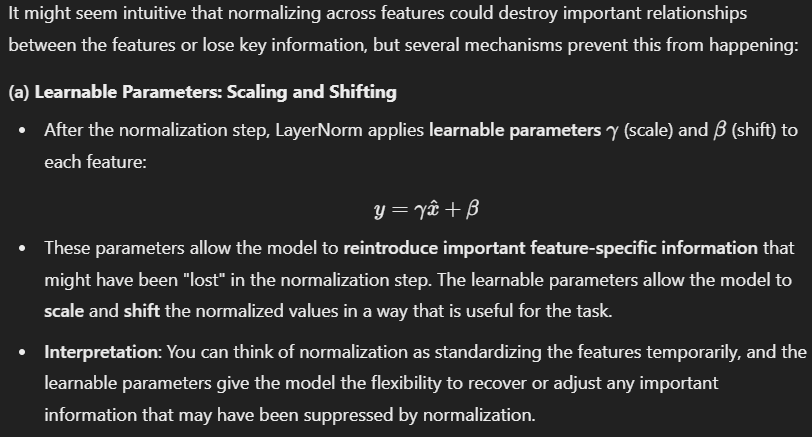

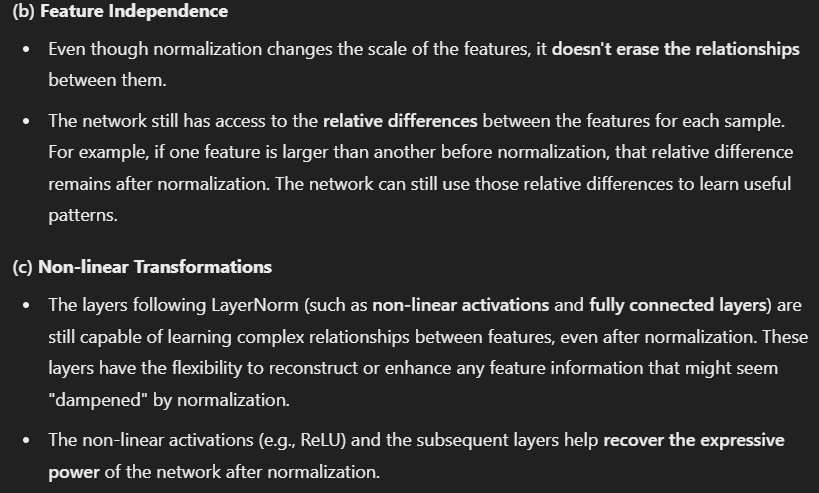

In [35]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



# 5) Full finished code, for reference

The implementation below follows the original paper, but keeps it at decoder-only:

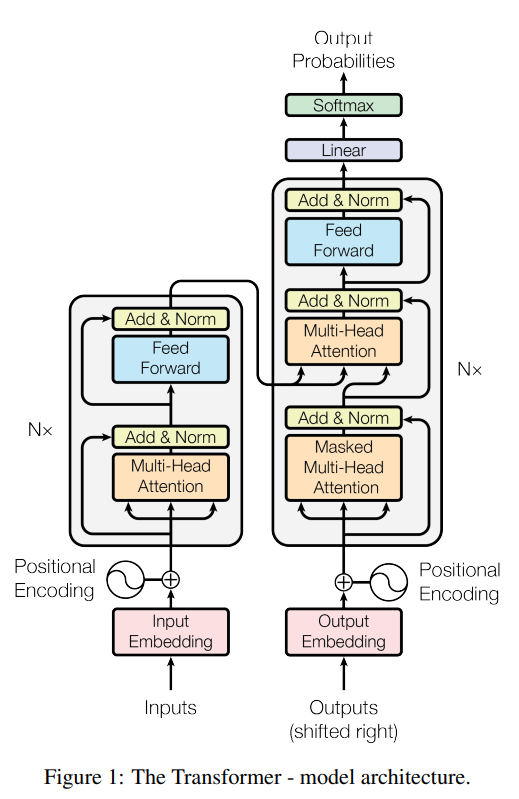

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

#!wget https://raw.githubusercontent.com/Paradox3333/0-to-transformers/main/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text:
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # Encoder: take a string, output a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: take a list of integers, output a string.

# Train and test splits:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # First 90% will be train, rest val.
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y:
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # register_buffer is a model definition utility.
        # It permanently marks a tensor as part of the module state, but not a parameter.
        # The optimizer ignores it, but it still moves with the model to_device and gets saved in the state_dict.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Compute attention scores ("affinities"):
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # Perform the weighted aggregation of the values:
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    # NOTE: In single-headed attention, each token in a sentence compares itself to all other tokens once
    # and calculates attention scores—which indicate how strongly each token relates to other tokens.
    # If you use only single-headed attention, you're forced to focus on all of this in one shot,
    # which may not capture all relationships effectively. Multi-headed attention allows the tokens to 
    # have multiple communication channels and do this multiple times in parallel, each time focusing on
    # different relationships.

    # Computationally, this is also similar to grouped convolutions, where instead of running one single large convolution
    # we run smaller convolutions in groups. 

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # Projection layer (linear transformation).
        # --> A learned linear recombination of all heads is needed to mix their information
        # and map it back into the same embedding space, instead of just naive concatenation.
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # # Concatenation of different attention heads.
        out = self.dropout(self.proj(out))  # Projection and then dropout.
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    # This layer acts on a per-token level. It is like a layer that gives time to the tokens to 'learn' about the
    # relationships discovered through attention.

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expansion layer (4x expansion, same as in the original paper).
            # --> The idea is to temporarily expand the dimensionality of the input. By mapping the
            # input to a higher-dimensional space, the network can create richer nonlinear combinations
            # and capture more complex patterns and relationships in the data.
            # This is sometimes referred to as increasing the model capacity.
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # Projection layer (compression).
            # --> After applying a non-linearity (in this case, ReLU), the data is projected back to the original
            # dimensionality n_embd to respect architectural constraints (dimensions have to work out).
            nn.Dropout(dropout),  # Dropout right before merging the connections back from residual.
        )

    def forward(self, x):
        return self.net(x)  # Per-token operations (no attention mechanism is applied here).

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    # Just like in the original "Attention is All You Need" paper, transformer blocks are stacked.

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like.
        super().__init__()
        head_size = n_embd // n_head  # Total attention dimensions remain fixed, so the dimensionality per head goes down.
        # --> Here, "n_embd" is 64 and "n_head" is 4, meaning each head gets 8D worth of attention to work with.
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # Multi-head attention with residual connection.
        x = x + self.ffwd(self.ln2(x))  # # Feedforward layer with residual connection.
        return x

# Super simple bigram model:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Create multiple instances of the Block class:
        # unpack the list of Blocks so it passes each Block in the list as a separate argument to nn.Sequential.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None): # Implement the compute path. Called by __call__. --> self(idx_cond).
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        # The input to this embedding layer is a tensor of positions, torch.arange(T), which produces values
        # from 0 to T-1 for each time step (token position) in the sequence:
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        # Add token and positional information:
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        # NOTE: Variables defined inside an if-else, for, while, or any other block within the same global or
        # local (function) scope are accessible outside of those blocks. This is because Python doesn't have 
        # block-level scoping like some other programming languages (such as C, C++, or Java). Instead, Python
        # uses function-level or module-level scoping.
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # "idx" is (B, T) array of indices in the current context:
        for _ in range(max_new_tokens):
            # Crop "idx" to keep only the last block_size tokens, otherwise an input tensor of "T" > "block_size"
            # would cause an out of bounds error when trying to embed:
            idx_cond = idx[:, -block_size:]
            # Get the predictions:
            logits, loss = self(idx_cond)
            # Focus only on the last time step:
            # The model predicts logits for every token in the sequence, returning a tensor logits of shape (B, T, vocab_size),
            # However, in the context of autoregressive generation, we only care about the next token prediction:
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution:
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence:
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# Print the number of parameters in the model:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Create a PyTorch optimizer:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # Every once in a while evaluate the loss on train and val sets:
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data:
    xb, yb = get_batch('train')

    # Evaluate the loss:
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Generate from the model:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5058
step 300: train loss 2.4197, val loss 2.4336
step 400: train loss 2.3501, val loss 2.3562
step 500: train loss 2.2963, val loss 2.3125
step 600: train loss 2.2407, val loss 2.2496
step 700: train loss 2.2054, val loss 2.2187
step 800: train loss 2.1633, val loss 2.1866
step 900: train loss 2.1241, val loss 2.1504
step 1000: train loss 2.1036, val loss 2.1306
step 1100: train loss 2.0698, val loss 2.1180
step 1200: train loss 2.0380, val loss 2.0791
step 1300: train loss 2.0248, val loss 2.0634
step 1400: train loss 1.9926, val loss 2.0359
step 1500: train loss 1.9697, val loss 2.0287
step 1600: train loss 1.9627, val loss 2.0477
step 1700: train loss 1.9403, val loss 2.0115
step 1800: train loss 1.9090, val loss 1.9941
step 1900: train loss 1.9092, val loss 1.9858
step 2000: train loss 1.8847, val loss 1.9925
step 2100: train loss 1.

In [ ]:
# Now with more complexity via hyperparameters:

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

#!wget https://raw.githubusercontent.com/Paradox3333/0-to-transformers/main/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text:
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # Encoder: take a string, output a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: take a list of integers, output a string.

# Train and test splits:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # First 90% will be train, rest val.
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y:
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Compute attention scores ("affinities"):
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # Perform the weighted aggregation of the values:
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd) # Projection layer (linear transformation).
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # # Concatenation of different attention heads.
        out = self.dropout(self.proj(out))  # Projection and then dropout.
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    # This layer acts on a per-token level. It is like a layer that gives time to the tokens to 'learn' about the relationships
    # discovered through attention.

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expansion layer (4x expansion, same as in the original paper).
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # Projection layer (compression).
            nn.Dropout(dropout),  # Dropout right before merging the connections back from residual.
        )

    def forward(self, x):
        return self.net(x)  # Per-token operations (no attention mechanism is applied here).

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    # Just like in the original "Attention is All You Need" paper, transformer blocks are stacked.

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like.
        super().__init__()
        head_size = n_embd // n_head  # Total attention dimensions remain fixed, so the dimensionality per head goes down.
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # Multi-head attention with residual connection.
        x = x + self.ffwd(self.ln2(x))  # # Feedforward layer with residual connection.
        return x

# Super simple bigram model:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        # The input to this embedding layer is a tensor of positions, torch.arange(T), which produces values
        # from 0 to T-1 for each time step (token position) in the sequence:
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        # Add token and positional information:
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # "idx" is (B, T) array of indices in the current context:
        for _ in range(max_new_tokens):
            # Crop "idx" to keep only the last block_size tokens, otherwise an input tensor of "T" > "block_size"
            # would cause an out of bounds error when trying to embed:
            idx_cond = idx[:, -block_size:]
            # Get the predictions:
            logits, loss = self(idx_cond)
            # Focus only on the last time step:
            # The model predicts logits for every token in the sequence, returning a tensor logits of shape (B, T, vocab_size),
            # However, in the context of autoregressive generation, we only care about the next token prediction:
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution:
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence:
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# Print the number of parameters in the model:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Create a PyTorch optimizer:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # Every once in a while evaluate the loss on train and val sets:
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data:
    xb, yb = get_batch('train')

    # Evaluate the loss:
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Generate from the model:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

10.788929 M parameters
step 0: train loss 4.2849, val loss 4.2823
step 500: train loss 2.0112, val loss 2.0971
step 1000: train loss 1.6021, val loss 1.7830
step 1500: train loss 1.4412, val loss 1.6396
step 2000: train loss 1.3430, val loss 1.5724
step 2500: train loss 1.2809, val loss 1.5330
step 3000: train loss 1.2268, val loss 1.5094
step 3500: train loss 1.1824, val loss 1.4881
step 4000: train loss 1.1475, val loss 1.4869
step 4500: train loss 1.1108, val loss 1.4805
step 4999: train loss 1.0779, val loss 1.4920

But with prison: I will stead with you.

ISABELLA:
Carress, all do; and I'll say your honour self good:
Then I'll regn your highness and
Compell'd by my sweet gates that you may:
Valiant make how I heard of you.

ANGELO:
Nay, sir, Isay!

ISABELLA:
I am sweet men sister as you steed.

LUCIO:
As it if you in the case would princily,
I'll rote, sir, I did cannot now at me?
That look thence, thy children shall be you called.

DUKE VINCENTIO:
Marry, though I do read you!

LU

# Notes:

## Transformer Training and Inference

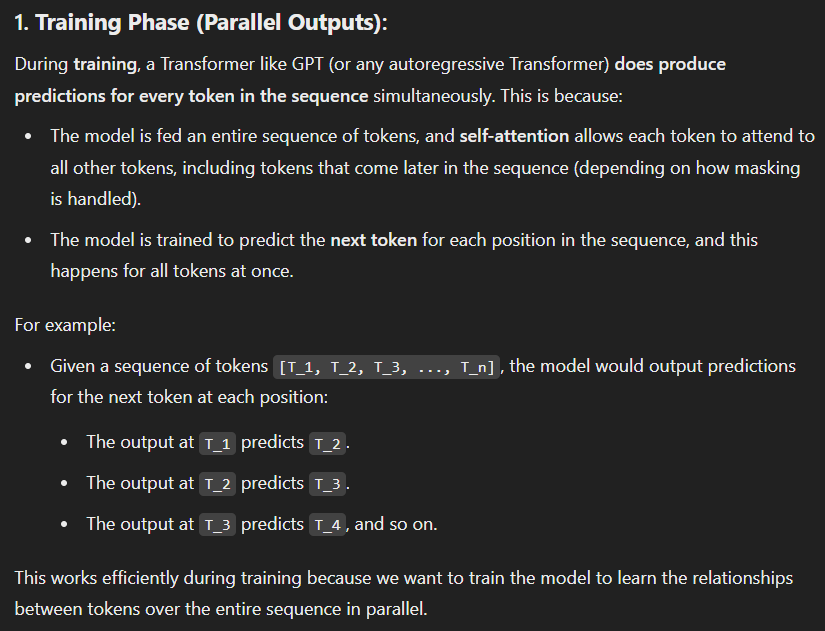

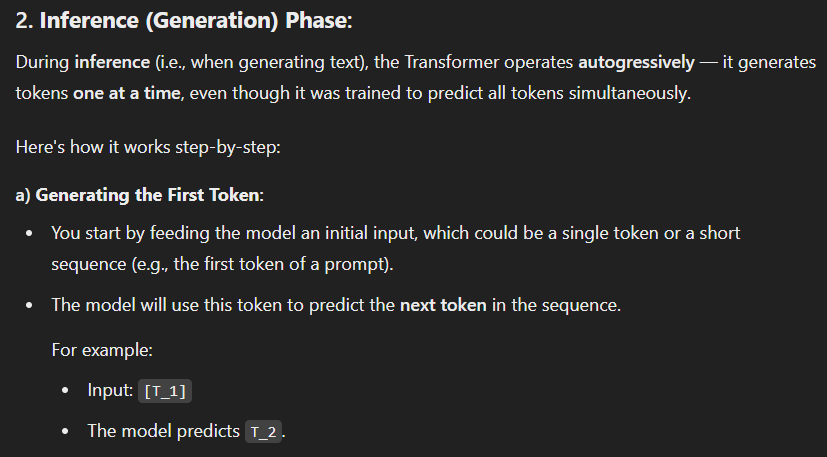

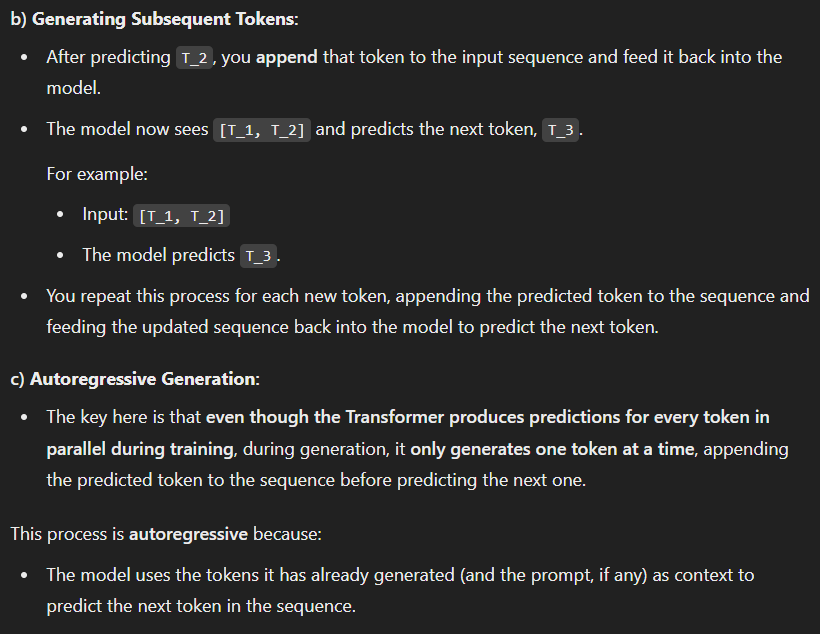

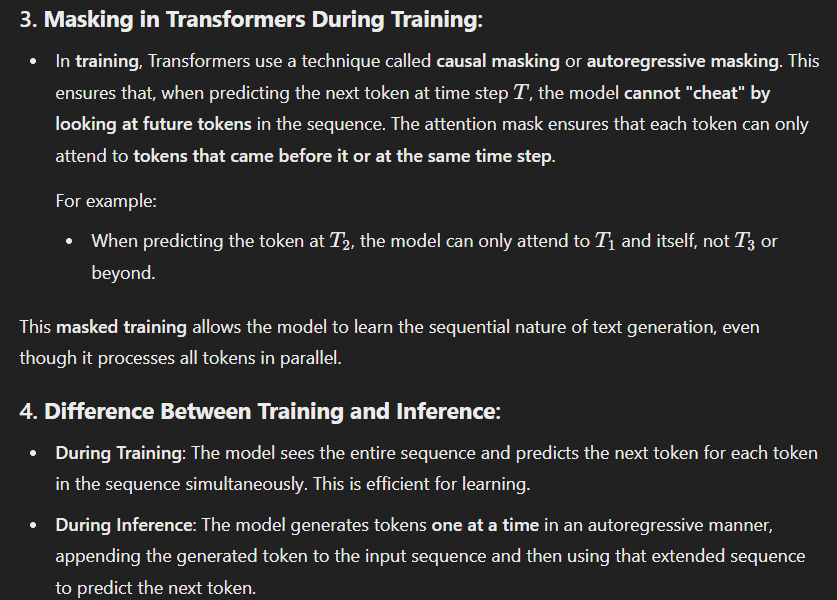

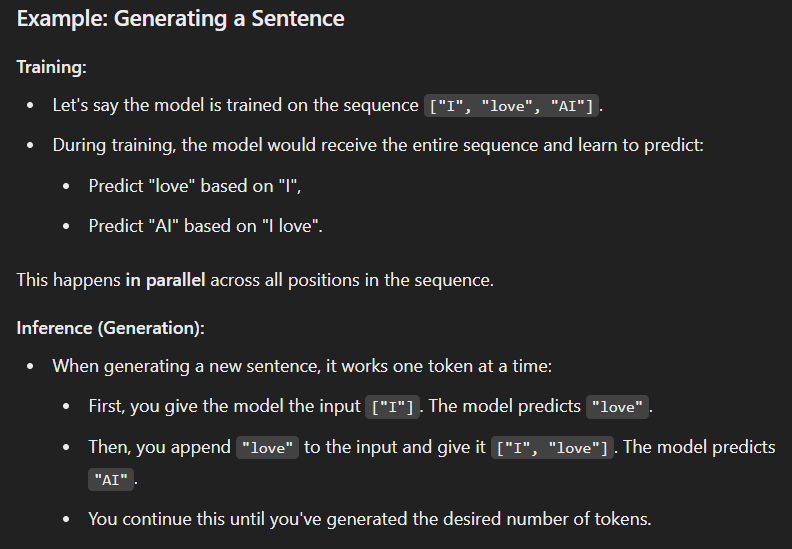

## Multi-headed attention

- In **single-headed attention**, each word in a sentence compares itself to all other words once and calculates attention scores—which indicate how strongly each word relates to other words.
If you use only single-headed attention, you're forced to focus on all of this in one shot, which may not capture all relationships effectively. **Multi-headed attention** allows the model to do this multiple times in parallel, each time focusing on different aspects of the sentence. This effectively increases the 'communication' channels between tokens.

- The embedding size C is a crucial fixed value because it determines the **total representational power** of the model. Multi-headed attention divides this capacity among the heads, but the overall model's representational power remains fixed at C. The goal is to balance this capacity between diversity (number of heads) and depth (size of each head).


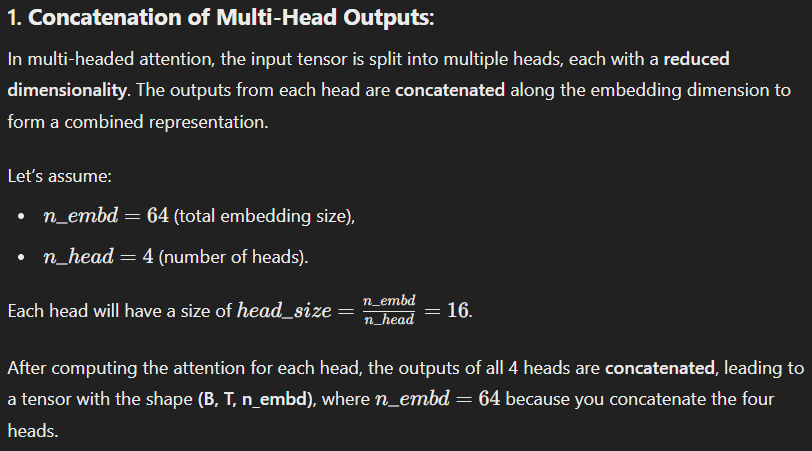

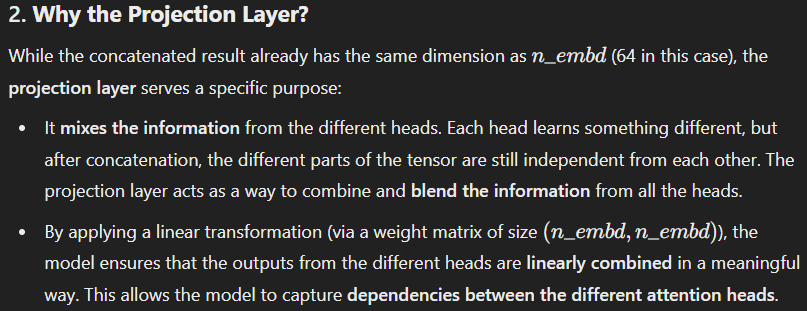

### FeedForward vs MultiHeadAttention: Projection layers

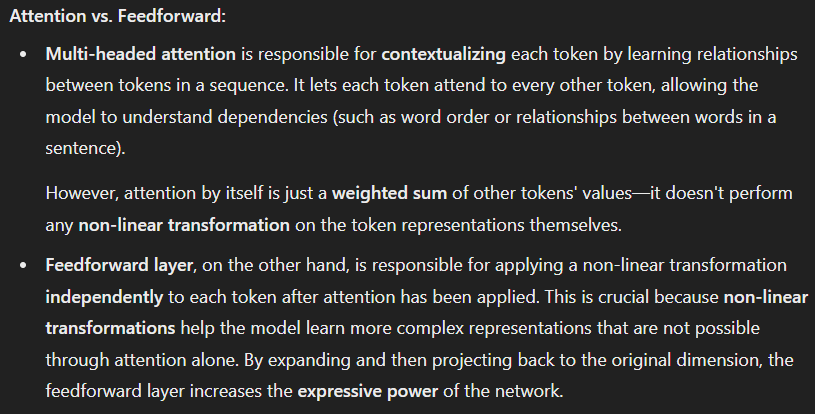

## Residual connections

- Residual connections (also known as skip connections) are a key component in many deep learning architectures, especially ResNets (Residual Networks) and transformers. They play a significant role in helping gradient flow during backpropagation and making it easier for the model to train deeper networks by bypassing or skipping some layers.

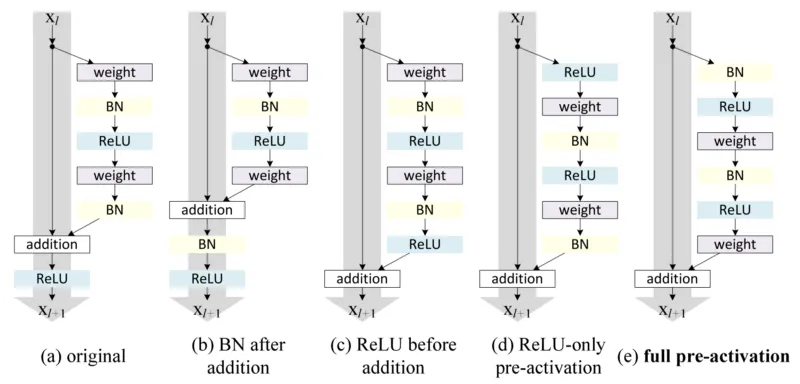

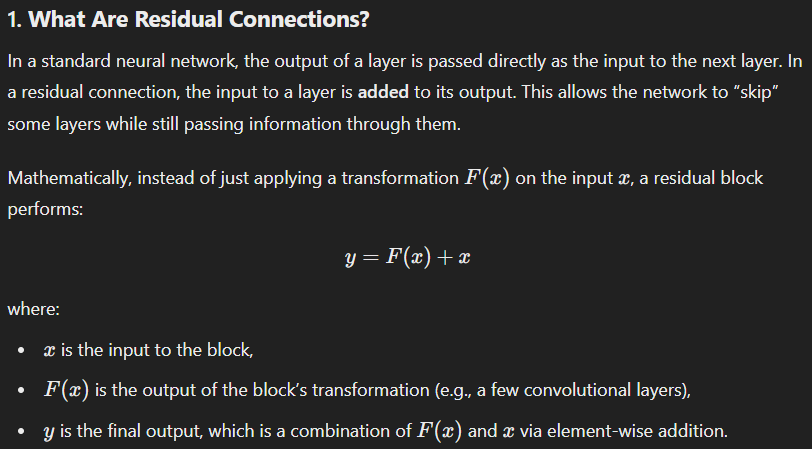

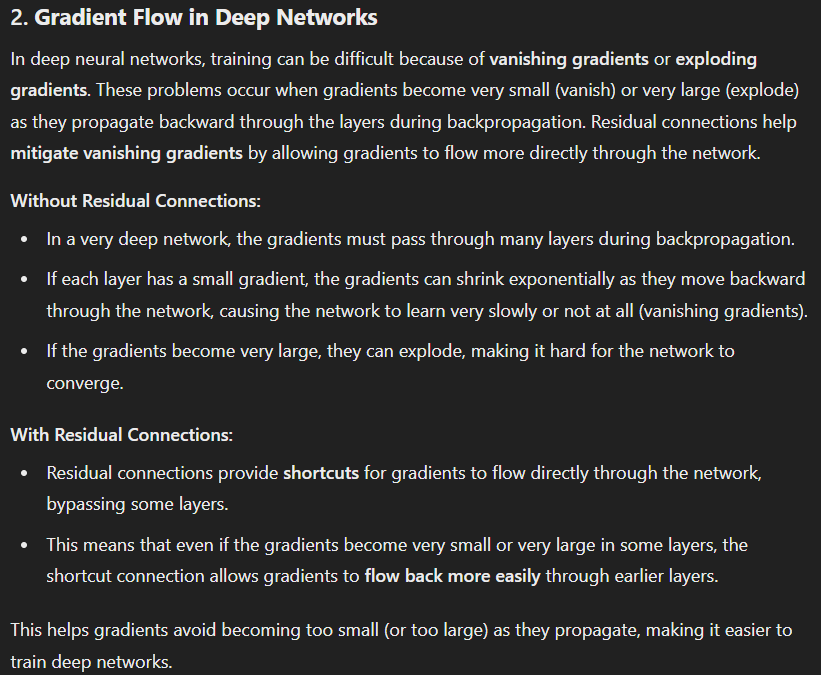

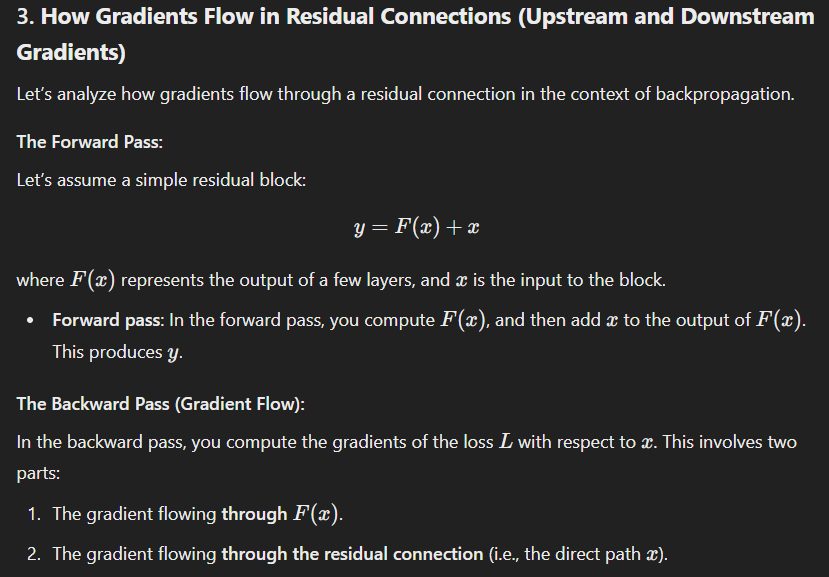

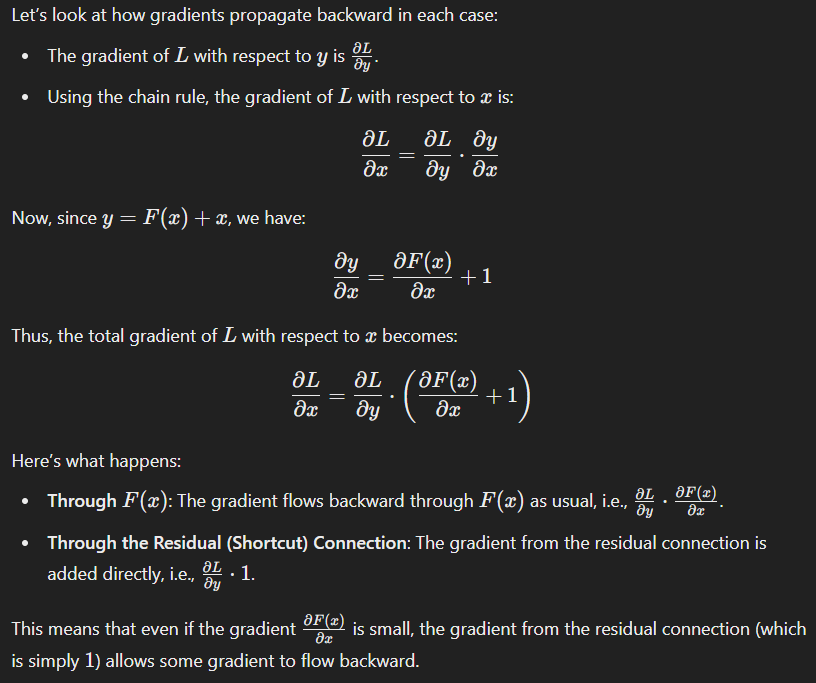

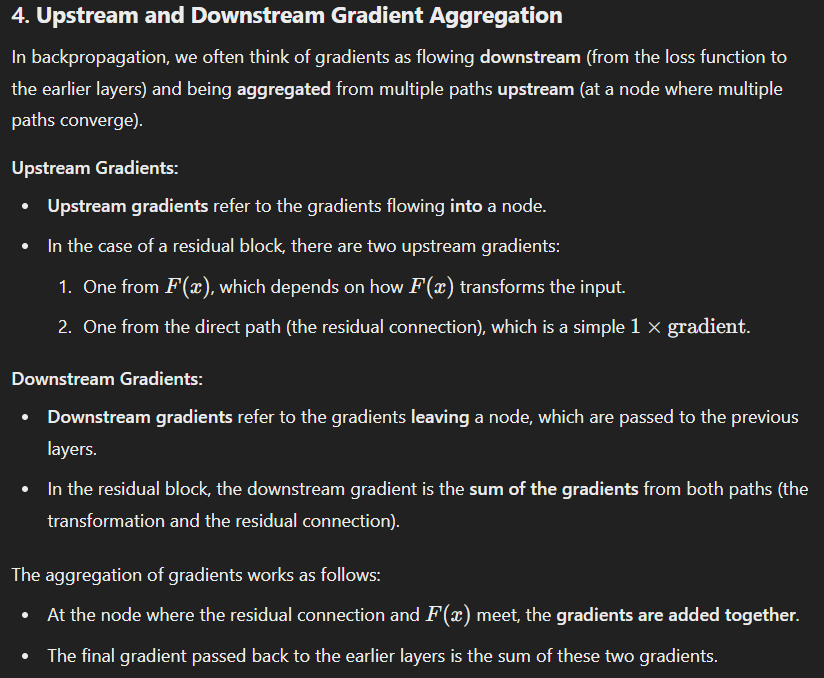

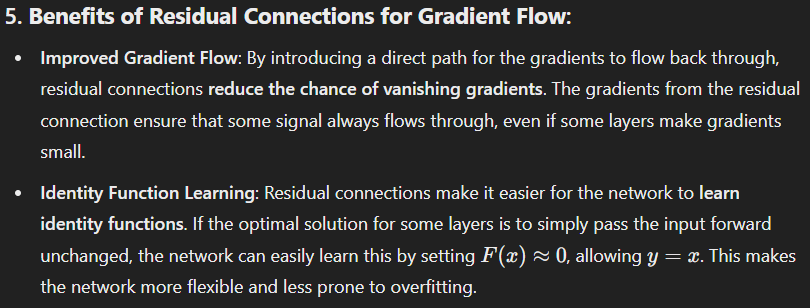